In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import *
from sklearn.model_selection import cross_val_score, StratifiedKFold
from joblib import parallel_backend
import shap
import pickle

# Custom modules
from ozzy_torch_utils.subject_dataset import *

np.set_printoptions(precision=2, suppress=True)

In [47]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort"

selected_labels = ['CN', 'MCI']

# Dictionary key representing the disease labels
labels_string = 'research_group'

In [48]:
dataset = SubjectDataset(data_path, selected_labels, data_string='volumes')

Csv files: ['/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort/idaSearch_3_19_2025.csv']


In [49]:
labels = np.array([dataset[index]['research_group'] for index in range(len(dataset.subject_list))])

volumes = np.array([dataset[index]['volumes'] for index in range(len(dataset.subject_list))])

print(f"Unique labels: {np.unique(labels, return_counts=True)}\n")

Unique labels: (array([0, 1]), array([195, 348]))



In [ ]:
args = {
    'learning_rate':0.5,
    'l2_regularization': 0,
    'max_leaf_nodes': 30,
    'max_features': 0.5,
}

with parallel_backend('threading', n_jobs=8):

    # model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)

    model = HistGradientBoostingClassifier(**args, class_weight='balanced')

    cv = StratifiedKFold(n_splits=10, shuffle=True)

    auc_scores = cross_val_score(model, volumes, labels, cv=cv, scoring='roc_auc')
    f1_scores = cross_val_score(model, volumes, labels, cv=cv, scoring='f1')

    print(f'Cross-validation AUC scores: {auc_scores}')
    print(f'Mean cross-validation AUC score: {np.mean(auc_scores)}')
    print(f'Standard deviation of cross-validation AUC: {np.std(auc_scores)}')
    print(f'Cross-validation f1 scores: {f1_scores}')
    print(f'Mean cross-validation f1 score: {np.mean(f1_scores)}')
    print(f'Standard deviation of cross-validation f1: {np.std(f1_scores)}')

Cross-validation AUC scores: [0.77 0.77 0.82 0.79 0.73 0.78 0.71 0.77 0.73 0.77]
Mean cross-validation AUC score: 0.7625048651039363
Standard deviation of cross-validation AUC: 0.03209721116932209
Cross-validation f1 scores: [0.75 0.76 0.71 0.75 0.82 0.74 0.77 0.84 0.84 0.74]
Mean cross-validation f1 score: 0.772248331594441
Standard deviation of cross-validation f1: 0.042960315433590614


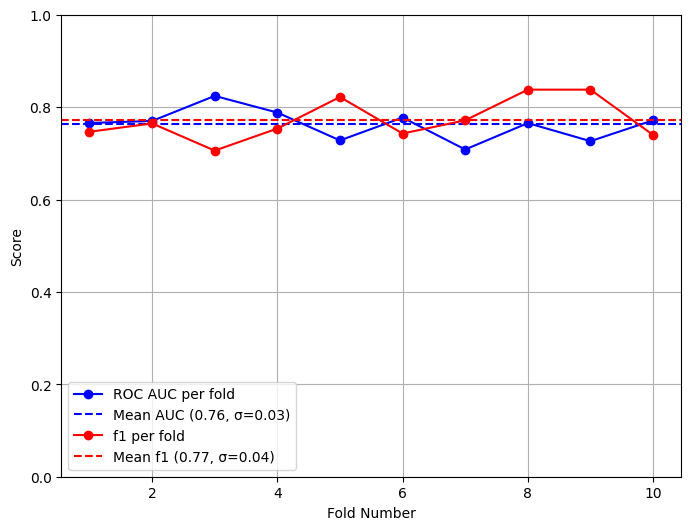

In [56]:

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(auc_scores) + 1), auc_scores, marker='o', color='b', linestyle='-', label=f'ROC AUC per fold')
plt.axhline(y=np.mean(auc_scores), color='b', linestyle='--', label=f'Mean AUC ({np.mean(auc_scores):.2f}, σ={np.std(auc_scores):.2f})')
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o', color='r', linestyle='-', label=f'f1 per fold')
plt.axhline(y=np.mean(f1_scores), color='r', linestyle='--', label=f'Mean f1 ({np.mean(f1_scores):.2f}, σ={np.std(f1_scores):.2f})')
plt.xlabel('Fold Number')
plt.ylabel(f'Score')
plt.ylim(0,1)
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/volumes_cv.npz', auc_scores=auc_scores, f1_scores=f1_scores)

543


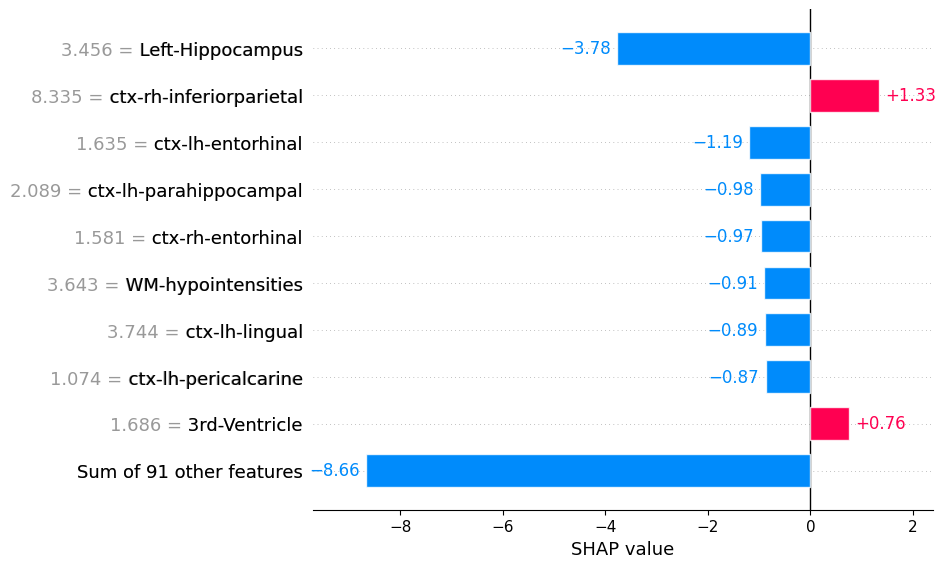

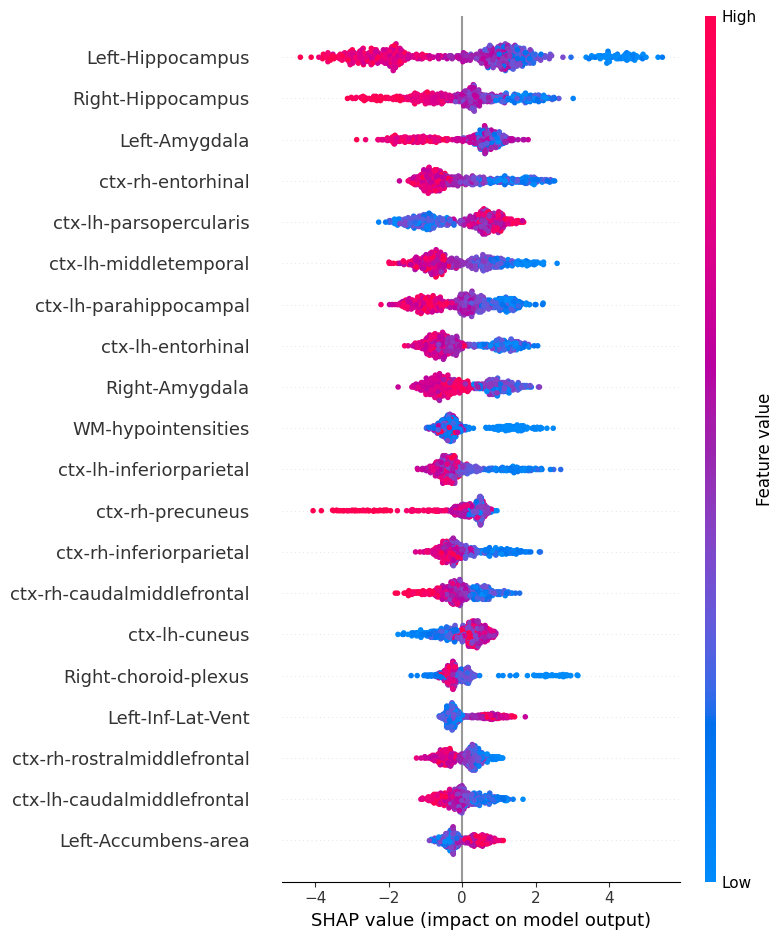

In [57]:
model.fit(volumes, labels)

explainer = shap.Explainer(model, feature_names=dataset[0]['struct_names'])

shap_values = explainer(volumes)

print(len(shap_values))

shap.plots.bar(shap_values[0], max_display=10)

shap.summary_plot(shap_values, volumes)


In [58]:
with open(f'volumes_gbdt.pkl', 'wb') as file:
    
    pickle.dump(model, file)  
